In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

from import_class import DataHandler
from CNN_class import CNN_3

print(tf.__version__)

2025-01-23 18:03:24.879344: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:03:24.885107: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 18:03:24.892365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 18:03:24.894561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:03:24.899934: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[gpuid], True)
    '''
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=12000)])
    '''
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1737680607.565421 4171026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737680607.588167 4171026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737680607.588267 4171026 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1737680607.590217 4171026 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    inputs = np.load("all_inputs_3.npy")

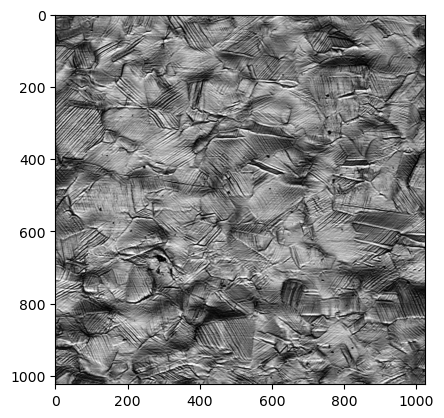

In [4]:
plt.imshow(inputs[0],cmap='grey')

In [5]:
with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
    targets = np.load("all_targets_3.npy")

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, AveragePooling2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.model_selection import GridSearch

# Configure cross-validation and early stopping
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    'k_dim': [9],
    'conv_dim': [32],
    'pool_dim': [3,5],
    'pooling_type': ['max', 'average'],  
    'learning_rate': [1e-5],
}

# Perform cross-validation with early stopping
best_params = None
best_score = 0
with tf.device('/CPU:0'):
    test_scores = {}
i = 1

for k_dim in param_grid['k_dim']:
    for conv_dim in param_grid['conv_dim']:
        for learning_rate in param_grid['learning_rate']:
            for pooling_type in param_grid['pooling_type']:
                for pool_dim in param_grid['pool_dim']:
                    total_models = len(param_grid['pooling_type'])*len(param_grid['pool_dim'])*len(param_grid['k_dim'])*len(param_grid['conv_dim'])*len(param_grid['learning_rate'])
                    print(f"testing model {i} out of {total_models}")
                    print(f'testing params: {pooling_type}, {pool_dim}, {k_dim}, {conv_dim},{learning_rate}')
                    i += 1

                    num_folds = 1
                    best_rounds = []
                    for train_index, test_index in kf.split(inputs, targets):
                        with tf.device("/CPU:0") :
                            X_train_fold, X_test_fold = inputs[train_index], inputs[test_index]
                            y_train_fold, y_test_fold = targets[train_index], targets[test_index]

                        with tf.device("/CPU:0") :
                            #X_train, X_test, y_train, y_test = train_test_split(train_index, test_index, test_size=0.2)
                            X_train_fold, X_val, y_train_fold, y_val = train_test_split(X_train_fold, y_train_fold, test_size=0.2, random_state=42)


                        with tf.device("/CPU:0") :
                            train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
                            val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

                        with tf.device("/GPU:0") :
                            batchsize = 32
                            train_dataset = train_dataset.shuffle(200).batch(batchsize)
                            val_dataset = val_dataset.shuffle(200).batch(batchsize)


                        early_stopping = EarlyStopping(
                        monitor="val_accuracy", 
                        patience=20, 
                        mode="max", 
                        restore_best_weights=True  # Automatically restores the best model weights
                        )

                        model_checkpoint = ModelCheckpoint(
                        filepath='checkpoint.model41.keras',
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True)

                        # Prepare the model
                        #k_dim=3
                        #conv_dim=16
                        #learning_rate=1e-4 
                        drop_rate=0
                        ff_dim=32
                        
                        model = Sequential([
                            Conv2D(conv_dim, kernel_size=(k_dim, k_dim), activation='relu', input_shape=(1024, 1024, 1)),
                            BatchNormalization(),
                            ReLU(),
                            MaxPooling2D(pool_size=(pool_dim, pool_dim)) if pooling_type == 'max' else AveragePooling2D(pool_size=(pool_dim, pool_dim)),
                            Dropout(drop_rate),
                            Conv2D(conv_dim, kernel_size=(k_dim, k_dim), padding='valid'),
                            BatchNormalization(),
                            ReLU(),
                            MaxPooling2D(pool_size=(pool_dim, pool_dim)) if pooling_type == 'max' else AveragePooling2D(pool_size=(pool_dim, pool_dim)),
                            Dropout(drop_rate),
                            Conv2D(conv_dim, kernel_size=(k_dim, k_dim), padding='valid'),
                            BatchNormalization(),
                            ReLU(),
                            MaxPooling2D(pool_size=(pool_dim, pool_dim)) if pooling_type == 'max' else AveragePooling2D(pool_size=(pool_dim, pool_dim)),
                            Dropout(drop_rate),
                            Flatten(),
                            Dense(ff_dim, activation='relu'),
                            Dropout(drop_rate),
                            Dense(1, activation='sigmoid')
                        ])
                        model.compile(optimizer=Adam(learning_rate=learning_rate),
                                    loss='binary_crossentropy',
                                    metrics=['accuracy'])

                        # Fit model on train fold and use validation for early stopping
                        model.fit(train_dataset, epochs = 1000, validation_data=val_dataset,callbacks=[early_stopping])

                        # Predict on test set
                        #y_pred_test = model.predict(X_test_fold)

                        test_loss, test_acc = model.evaluate(X_test_fold, y_test_fold)
                        #test_scores[f'fold:{num_folds}, pooling_type: {pooling_type}, pool_dim: {pool_dim}, k_dim: {k_dim}, conv_dim: {conv_dim}, learning_rate: {learning_rate}'] = {"loss":test_loss, "accuracy":test_acc}
                            
                        with tf.device('/CPU:0'):
                            test_scores[f'fold:{num_folds}, pooling_type: {pooling_type}, pool_dim: {pool_dim}, k_dim: {k_dim}, conv_dim: {conv_dim}, learning_rate: {learning_rate}'] = {"loss":test_loss, "accuracy":test_acc}


                        num_folds += 1

testing model 1 out of 4
testing params: max, 3, 9, 32,1e-05


/home/bea/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000


I0000 00:00:1737680640.085534 4171171 service.cc:146] XLA service 0x74d8ec407890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737680640.085550 4171171 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-01-23 18:04:00.106246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 18:04:00.218245: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
E0000 00:00:1737680642.013835 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680642.105777 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sy

69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5349 - loss: 0.8021

E0000 00:00:1737680678.088182 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680678.172723 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680678.256862 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5349 - loss: 0.8016

E0000 00:00:1737680687.260659 4171160 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680687.353802 4171160 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680688.955475 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737680689.040298 4171171 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 54s 398ms/step - accuracy: 0.5350 - loss: 0.8012 - val_accuracy: 0.5189 - val_loss: 0.6929
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.6184 - loss: 0.6579 - val_accuracy: 0.4793 - val_loss: 0.7419
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.6270 - loss: 0.6423 - val_accuracy: 0.4793 - val_loss: 0.8455
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.6748 - loss: 0.5945 - val_accuracy: 0.4793 - val_loss: 0.8017
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.7274 - loss: 0.5584 - val_accuracy: 0.4793 - val_loss: 1.0126
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.7664 - loss: 0.5142 - val_accuracy: 0.4793 - val_loss: 1.1287
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.7906 - loss: 0.4710 - val_accuracy: 0.4793 - val_loss: 1.4126
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.8385 - loss: 0.4189 - val_a

E0000 00:00:1737682224.698121 4171172 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737682224.788453 4171172 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.8863 - loss: 0.3336
Epoch 1/1000


2025-01-23 18:30:34.640385: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.79GiB (12658709398 bytes) by rematerialization; only reduced to 12.26GiB (13168541964 bytes), down from 12.26GiB (13168573356 bytes) originally


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.5216 - loss: 0.8000 - val_accuracy: 0.5189 - val_loss: 0.6925
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.5647 - loss: 0.6849 - val_accuracy: 0.4811 - val_loss: 0.7223
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6276 - loss: 0.6454 - val_accuracy: 0.4811 - val_loss: 0.8588
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6818 - loss: 0.5914 - val_accuracy: 0.4811 - val_loss: 1.0967
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.7169 - loss: 0.5570 - val_accuracy: 0.4811 - val_loss: 1.2756
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.7885 - loss: 0.4925 - val_accuracy: 0.4811 - val_loss: 1.5299
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.8097 - loss: 0.4485 - val_accuracy: 0.4811 - val_loss: 1.7132
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.8661 - loss: 0.3807 - val_a

2025-01-23 18:49:07.242578: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.79GiB (12658709398 bytes) by rematerialization; only reduced to 12.26GiB (13168541964 bytes), down from 12.26GiB (13168573356 bytes) originally


69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4817 - loss: 0.7920

E0000 00:00:1737683362.839608 4171175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737683362.926200 4171175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737683363.010656 4171175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.4824 - loss: 0.7906 - val_accuracy: 0.4811 - val_loss: 0.6964
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.5850 - loss: 0.6693 - val_accuracy: 0.4811 - val_loss: 0.7063
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6254 - loss: 0.6482 - val_accuracy: 0.4811 - val_loss: 0.7091
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6736 - loss: 0.6137 - val_accuracy: 0.4811 - val_loss: 0.7292
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.7200 - loss: 0.5710 - val_accuracy: 0.4811 - val_loss: 0.6978
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.7598 - loss: 0.5338 - val_accuracy: 0.4901 - val_loss: 0.7294
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.7981 - loss: 0.4779 - val_accuracy: 0.5081 - val_loss: 0.7584
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.7821 - loss: 0.4555 - val_a

E0000 00:00:1737685308.558882 4171175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1737685308.669368 4171175 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8804 - loss: 0.3188
Epoch 1/1000


2025-01-23 19:21:58.611034: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.79GiB (12658709398 bytes) by rematerialization; only reduced to 12.26GiB (13168541964 bytes), down from 12.26GiB (13168573356 bytes) originally


70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 253ms/step - accuracy: 0.5415 - loss: 0.7743 - val_accuracy: 0.4811 - val_loss: 0.7402
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.5848 - loss: 0.6778 - val_accuracy: 0.4811 - val_loss: 0.7670
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 223ms/step - accuracy: 0.6393 - loss: 0.6299 - val_accuracy: 0.4811 - val_loss: 0.8181
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6790 - loss: 0.5830 - val_accuracy: 0.4811 - val_loss: 0.8908
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.7368 - loss: 0.5319 - val_accuracy: 0.4811 - val_loss: 0.8179
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.7940 - loss: 0.4610 - val_accuracy: 0.4811 - val_loss: 0.8497
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.8651 - loss: 0.3857 - val_accuracy: 0.4811 - val_loss: 1.1586
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.8793 - loss: 0.3408 - val_a

2025-01-23 19:51:51.824159: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.79GiB (12658709398 bytes) by rematerialization; only reduced to 12.26GiB (13168541964 bytes), down from 12.26GiB (13168573356 bytes) originally


70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 0.5254 - loss: 0.8285 - val_accuracy: 0.4793 - val_loss: 0.6932
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 227ms/step - accuracy: 0.5558 - loss: 0.6847 - val_accuracy: 0.4811 - val_loss: 0.7189
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.5882 - loss: 0.6654 - val_accuracy: 0.4811 - val_loss: 0.7519
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.6306 - loss: 0.6411 - val_accuracy: 0.4811 - val_loss: 0.8073
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.6611 - loss: 0.6091 - val_accuracy: 0.4811 - val_loss: 0.8644
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.6992 - loss: 0.5766 - val_accuracy: 0.4811 - val_loss: 1.0263
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.7484 - loss: 0.5511 - val_accuracy: 0.4811 - val_loss: 1.0317
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.7855 - loss: 0.5001 - val_a

/home/bea/anaconda3/envs/tf2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-01-23 20:23:21.321286: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.80GiB (12671783830 bytes) by rematerialization; only reduced to 11.97GiB (12855628044 bytes), down from 11.97GiB (12855659436 bytes) originally


70/70 ━━━━━━━━━━━━━━━━━━━━ 24s 232ms/step - accuracy: 0.4429 - loss: 1.1554 - val_accuracy: 0.4793 - val_loss: 0.7391
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.5575 - loss: 0.6886 - val_accuracy: 0.4793 - val_loss: 0.8443
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.5967 - loss: 0.6584 - val_accuracy: 0.4793 - val_loss: 0.9511
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.6442 - loss: 0.6346 - val_accuracy: 0.4793 - val_loss: 1.0249
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.6707 - loss: 0.6145 - val_accuracy: 0.4793 - val_loss: 1.0469
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.7073 - loss: 0.5904 - val_accuracy: 0.4793 - val_loss: 1.0555
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.7480 - loss: 0.5690 - val_accuracy: 0.4793 - val_loss: 1.0894
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.7708 - loss: 0.5472 - val_a

2025-01-23 20:34:07.725411: W external/local_xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.80GiB (12671783830 bytes) by rematerialization; only reduced to 11.97GiB (12855628044 bytes), down from 11.97GiB (12855659436 bytes) originally


70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.4822 - loss: 0.8083 - val_accuracy: 0.5189 - val_loss: 0.6945
Epoch 2/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.5863 - loss: 0.6765 - val_accuracy: 0.5189 - val_loss: 0.6970
Epoch 3/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.6298 - loss: 0.6457 - val_accuracy: 0.5189 - val_loss: 0.6951
Epoch 4/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.6542 - loss: 0.6153 - val_accuracy: 0.5171 - val_loss: 0.6945
Epoch 5/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.6984 - loss: 0.5798 - val_accuracy: 0.5045 - val_loss: 0.6946
Epoch 6/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.7279 - loss: 0.5534 - val_accuracy: 0.4901 - val_loss: 0.6983
Epoch 7/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.7634 - loss: 0.5311 - val_accuracy: 0.4811 - val_loss: 0.7395
Epoch 8/1000
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.7883 - loss: 0.5031 - val_a

In [1]:
test_scores

NameError: name 'test_scores' is not defined

In [8]:
def make_results_df(test_scores):
    # Initialize a dictionary to aggregate results
    aggregated_results = {}

    for key, metrics in test_scores.items():
        # Parse the key to extract the hyperparameter combination (remove fold info)
        params = key
        
        # Initialize an entry in the results dictionary if not already present
        if params not in aggregated_results:
            aggregated_results[params] = {'loss': [], 'accuracy': []}
        
        # Append loss and accuracy for this fold
        aggregated_results[params]['loss'].append(metrics['loss'])
        aggregated_results[params]['accuracy'].append(metrics['accuracy'])

    # Create a DataFrame to store averaged results
    results_list = []
    for params, metrics in aggregated_results.items():
        loss = metrics['loss'][0]
        accuracy = metrics['accuracy'][0]
        results_list.append({'params': params, 'loss': loss, 'accuracy': accuracy})

    # Convert to DataFrame
    results_df = pd.DataFrame(results_list).set_index('params')
    return results_df

raw_result_df1 = make_results_df(test_scores) 
raw_result_df1.head()

,loss,accuracy
params,,
"fold:1, pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.460425,0.854467
"fold:2, pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.454046,0.832853
"fold:3, pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.332044,0.862915
"fold:4, pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.393628,0.847042
"fold:5, pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.362265,0.848485


In [ ]:
#raw_result_df = pd.concat([raw_result_df1,raw_result_df2])

In [9]:
raw_result_df1.to_csv("2025-1-23_gridsearch_intensity1024-5.csv")

In [10]:
def calculate_average_scores_df(test_scores):
    # Initialize a dictionary to aggregate results
    aggregated_results = {}

    for key, metrics in test_scores.items():
        # Parse the key to extract the hyperparameter combination (remove fold info)
        params = ', '.join([part for part in key.split(', ') if not part.startswith('fold')])
        
        # Initialize an entry in the results dictionary if not already present
        if params not in aggregated_results:
            aggregated_results[params] = {'loss': [], 'accuracy': []}
        
        # Append loss and accuracy for this fold
        aggregated_results[params]['loss'].append(metrics['loss'])
        aggregated_results[params]['accuracy'].append(metrics['accuracy'])

    # Create a DataFrame to store averaged results
    results_list = []
    for params, metrics in aggregated_results.items():
        avg_loss = sum(metrics['loss']) / len(metrics['loss'])
        avg_accuracy = sum(metrics['accuracy']) / len(metrics['accuracy'])
        results_list.append({'params': params, 'average_loss': avg_loss, 'average_accuracy': avg_accuracy})

    # Convert to DataFrame
    results_df = pd.DataFrame(results_list).set_index('params')
    return results_df

In [11]:
averaged_results2 = calculate_average_scores_df(test_scores)
averaged_results2

,average_loss,average_accuracy
params,,
"pooling_type: max, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.400482,0.849152
"pooling_type: max, pool_dim: 5, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.431975,0.807039
"pooling_type: average, pool_dim: 3, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.306470,0.872808
"pooling_type: average, pool_dim: 5, k_dim: 9, conv_dim: 16, learning_rate: 1e-05",0.227827,0.905403


In [23]:
averaged_results = pd.concat([averaged_results1,averaged_results2])
averaged_results

,average_loss,average_accuracy
params,,
"pooling_type: max, pool_dim: 3, k_dim: 3, conv_dim: 16, learning_rate: 1e-05",0.489163,0.763474
"pooling_type: max, pool_dim: 5, k_dim: 3, conv_dim: 16, learning_rate: 1e-05",0.619176,0.643802
"pooling_type: average, pool_dim: 3, k_dim: 3, conv_dim: 16, learning_rate: 1e-05",0.389992,0.812508
"pooling_type: average, pool_dim: 5, k_dim: 3, conv_dim: 16, learning_rate: 1e-05",0.510783,0.734044
"pooling_type: max, pool_dim: 3, k_dim: 3, conv_dim: 32, learning_rate: 1e-05",0.437262,0.796359
"pooling_type: max, pool_dim: 5, k_dim: 3, conv_dim: 32, learning_rate: 1e-05",0.539058,0.727433
"pooling_type: average, pool_dim: 3, k_dim: 3, conv_dim: 32, learning_rate: 1e-05",0.318983,0.860107
"pooling_type: average, pool_dim: 5, k_dim: 3, conv_dim: 32, learning_rate: 1e-05",0.375471,0.834150
"pooling_type: max, pool_dim: 3, k_dim: 5, conv_dim: 16, learning_rate: 1e-05",0.594976,0.661689


In [12]:
averaged_results2.to_csv("2025-1-23_gridsearch_averaged_results_intensity1024-5.csv")

In [13]:
def find_best_hyperparameters_df(results_df):
    # Find the row with the highest average_accuracy
    best_row = results_df.loc[results_df['average_accuracy'].idxmax()]
    
    # Extract the best parameters, loss, and accuracy
    best_params = best_row.name  # The index contains the parameter combination
    best_loss = best_row['average_loss']
    best_accuracy = best_row['average_accuracy']
    
    return best_params, best_loss, best_accuracy

best_params, best_loss, best_accuracy = find_best_hyperparameters_df(averaged_results2)
print(f"Best Parameters: {best_params}")
print(f"Best Loss: {best_loss:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")

Best Parameters: pooling_type: average, pool_dim: 5, k_dim: 9, conv_dim: 16, learning_rate: 1e-05
Best Loss: 0.2278
Best Accuracy: 0.9054
